In [505]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_dice_roll_frequency(rolls, title="Frequency of Rolls", outlier_threshold=None):
    """
    Plots the frequency of each value in a list of dice rolls as a bar graph.
    Optionally removes outliers with very low relative frequency.

    Args:
        rolls (list): A list of integers representing dice roll outcomes.
        outlier_threshold (float, optional): Minimum relative frequency (0–1)
            required for a value to be included in the plot.
            Example: 0.01 means values occurring in <1% of rolls are excluded.
    """
    if not rolls:
        print("The list of rolls is empty. Nothing to plot.")
        return

    # Calculate the frequency of each roll value
    frequencies = Counter(rolls)
    total_rolls = len(rolls)

    # Dynamically determine the full range of values present
    min_val, max_val = min(rolls), max(rolls)
    all_possible_rolls = range(min_val, max_val + 1)

    # Apply outlier filtering if threshold is provided
    if outlier_threshold is not None:
        filtered_rolls = [
            roll for roll in all_possible_rolls
            if frequencies.get(roll, 0) / total_rolls >= outlier_threshold
        ]
    else:
        filtered_rolls = list(all_possible_rolls)

    counts = [frequencies.get(roll, 0) for roll in filtered_rolls]

    # Create the bar graph
    plt.figure(figsize=(8, 5))
    plt.bar(filtered_rolls, counts,
            tick_label=list(map(str, filtered_rolls)),
            color='skyblue')

    plt.xlabel("Roll Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(filtered_rolls)  # Ensure ticks match observed values
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [506]:
import numpy as np

def roll_dice_uniform():
    """
    Simulates a single dice roll using numpy's uniform sampling.
    Outputs a value between 1 and 6 (inclusive).
    """
    # Generate a uniform random number between 0 (inclusive) and 1 (exclusive)
    random_float = np.random.uniform(0, 1)

    # Discretize the float to an integer between 1 and 6
    # Multiplying by 6 gives a range [0, 6)
    # floor converts it to an integer [0, 5]
    # Adding 1 shifts the range to [1, 6]
    dice_output = int(np.floor(random_float * 6)) + 1

    return dice_output

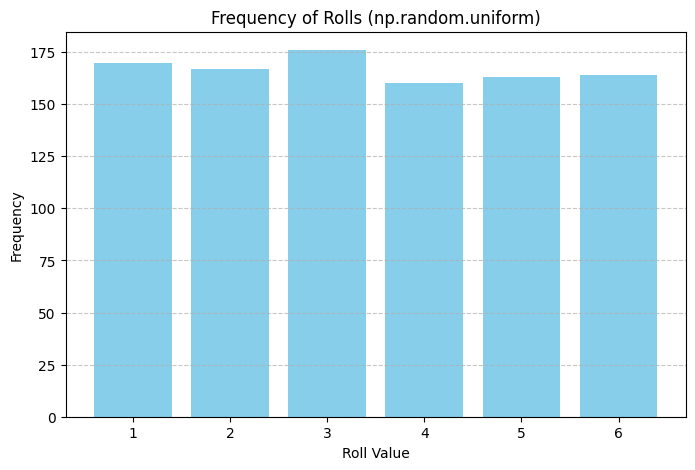

In [507]:
uniform_rolls = [roll_dice_uniform() for _ in range(1000)]

plot_dice_roll_frequency(uniform_rolls, title="Frequency of Rolls (np.random.uniform)")

In [508]:
import numpy as np
from scipy.stats import truncnorm

def truncated_normal(mean=0.5, sd=0.2, low=0.0, high=1.0, size=1):
    """
    Draw samples from a truncated normal distribution within [low, high].
    Useful for initializing values that must stay bounded.
    """
    a, b = (low - mean) / sd, (high - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

def roll_dice_langevin(gradient_fn, num_iter=1000, epsilon=1e-4):
    """
    Simulates a single dice roll using Langevin dynamics.
    Ensures output is always between 1 and 6 inclusive.

    Args:
        gradient_fn (callable): Function that computes gradient at x.
        num_iter (int): Number of Langevin iterations.
        epsilon (float): Step size.

    Returns:
        int: Dice roll outcome (1–6).
    """
    if gradient_fn is None:
        raise ValueError("gradient_fn cannot be None")

    # Initialize in [0,1] domain using Gaussian distribution
    x0 = truncated_normal(size=1)[0]

    # Pre-generate Gaussian noise terms
    noise = np.random.normal(0, 1, size=num_iter)

    # Langevin updates
    for zt in noise:
        x0 += (epsilon / 2) * gradient_fn(x0) + np.sqrt(epsilon) * zt
        # Keep inside [0,1]
        x0 = np.clip(x0, 0, 1)

    # Map [0,1] → {1,...,6}
    roll = int(np.clip(np.floor(x0 * 6) + 1, 1, 6))
    return roll

In [509]:
def dice_roll_gradient_fn_generator(slope_factor=1):
  """
  Generates a piecewise gradient function with the following behavior:
    - Returns -slope_factor * x if x < 0
    - Returns 0 if 0 <= x <= 1
    - Returns +slope_factor * x if x > 1
  """
  def dice_roll_gradient_fn(x):
    """
    Returns a gradient proportional to distance outside [0,1].
    """
    if x < 0:
      return slope_factor * x
    elif x > 1:
      return -slope_factor * (x-1)
    else:
      return 0

  return dice_roll_gradient_fn

In [492]:
dice_roll_gradient_fn = dice_roll_gradient_fn_generator(slope_factor=100)

[3, 3, 3, 2, 1, 3, 5, 5, 5, 3, 2, 3, 2, 4, 6, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 2, 2, 5, 4, 4, 2, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 2, 5, 5, 4, 4, 2, 4, 5, 2, 3, 1, 5, 5, 4, 3, 3, 2, 3, 4, 4, 3, 3, 3, 5, 6, 3, 2, 3, 5, 4, 5, 4, 4, 4, 4, 5, 3, 4, 3, 4, 3, 5, 5, 4, 3, 4, 4, 3, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 4, 3, 4, 3, 3, 3, 3, 2, 1, 5, 3, 2, 3, 1, 3, 5, 3, 5, 3, 4, 5, 4, 5, 3, 1, 5, 4, 3, 5, 5, 2, 3, 3, 3, 5, 3, 3, 3, 1, 5, 2, 2, 4, 3, 3, 2, 4, 4, 2, 4, 4, 2, 6, 2, 3, 4, 4, 4, 2, 2, 4, 5, 4, 4, 4, 5, 4, 5, 3, 4, 3, 2, 3, 3, 2, 2, 4, 2, 3, 2, 2, 4, 3, 3, 6, 5, 2, 3, 4, 5, 4, 2, 3, 4, 3, 3, 3, 4, 5, 2, 3, 2, 3, 5, 5, 4, 5, 4, 4, 2, 3, 3, 1, 4, 5, 2, 4, 3, 4, 3, 2, 4, 4, 3, 3, 3, 4, 4, 1, 4, 4, 3, 3, 4, 1, 4, 1, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 6, 5, 3, 3, 3, 4, 5, 4, 1, 4, 2, 5, 3, 5, 2, 5, 3, 2, 5, 5, 2, 3, 2, 2, 3, 4, 5, 4, 3, 3, 3, 5, 3, 2, 1, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 5, 5, 5, 4, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 3, 3, 2, 2, 4, 4, 4, 4, 3, 4, 1, 3, 3, 4, 2, 3, 3, 3, 4, 

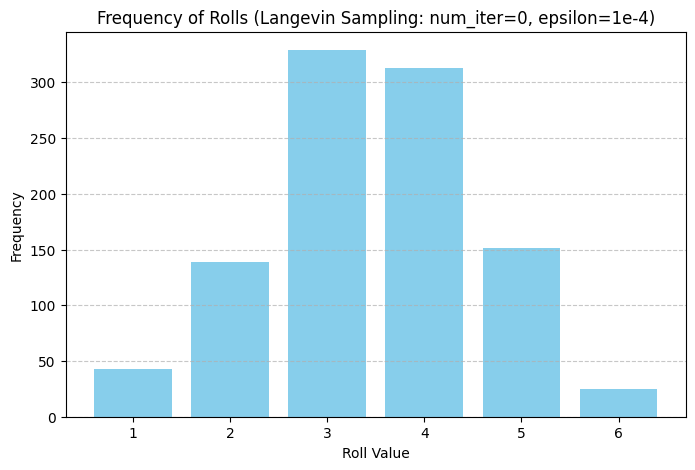

In [512]:
langevin_die_samples = [roll_dice_langevin(dice_roll_gradient_fn, num_iter=0, epsilon=1e-4) for _ in range(1000)]
print(langevin_die_samples)
plot_dice_roll_frequency(langevin_die_samples, title="Frequency of Rolls (Langevin Sampling: num_iter=0, epsilon=1e-4)")

[2, 4, 6, 3, 5, 6, 3, 3, 4, 3, 5, 4, 3, 3, 4, 5, 4, 3, 4, 2, 3, 4, 4, 4, 3, 5, 2, 5, 2, 5, 3, 3, 2, 4, 2, 3, 1, 5, 3, 5, 5, 2, 5, 5, 3, 3, 5, 3, 1, 1, 1, 5, 1, 5, 4, 2, 2, 4, 4, 3, 3, 5, 2, 4, 3, 4, 3, 1, 2, 1, 5, 2, 2, 3, 4, 5, 6, 3, 6, 4, 2, 3, 5, 4, 3, 2, 3, 1, 5, 5, 3, 4, 2, 1, 4, 2, 4, 1, 3, 6, 3, 6, 2, 2, 3, 3, 2, 4, 3, 3, 2, 3, 3, 4, 5, 2, 3, 2, 4, 4, 3, 4, 6, 2, 3, 3, 6, 3, 4, 6, 2, 1, 1, 3, 5, 5, 3, 3, 3, 6, 5, 4, 2, 1, 5, 4, 4, 2, 2, 5, 4, 5, 2, 3, 5, 4, 1, 2, 1, 1, 3, 5, 1, 4, 3, 3, 1, 2, 4, 3, 4, 5, 2, 1, 2, 4, 5, 3, 5, 4, 5, 3, 6, 3, 4, 6, 1, 6, 6, 2, 1, 3, 1, 6, 6, 5, 6, 3, 4, 4, 4, 1, 6, 2, 2, 5, 5, 1, 6, 6, 6, 1, 1, 2, 3, 5, 3, 4, 5, 5, 6, 4, 4, 6, 1, 1, 3, 5, 1, 2, 4, 3, 4, 2, 4, 3, 2, 4, 4, 4, 5, 2, 2, 1, 1, 3, 4, 3, 6, 6, 4, 3, 1, 1, 2, 3, 4, 5, 5, 3, 4, 6, 2, 5, 1, 6, 3, 3, 6, 5, 4, 6, 6, 3, 2, 2, 4, 4, 4, 4, 4, 2, 5, 4, 2, 5, 6, 3, 3, 4, 4, 4, 4, 5, 1, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 5, 6, 1, 3, 5, 6, 3, 1, 4, 1, 4, 6, 1, 5, 5, 4, 4, 6, 6, 6, 5, 5, 2, 4, 3, 5, 3, 3, 

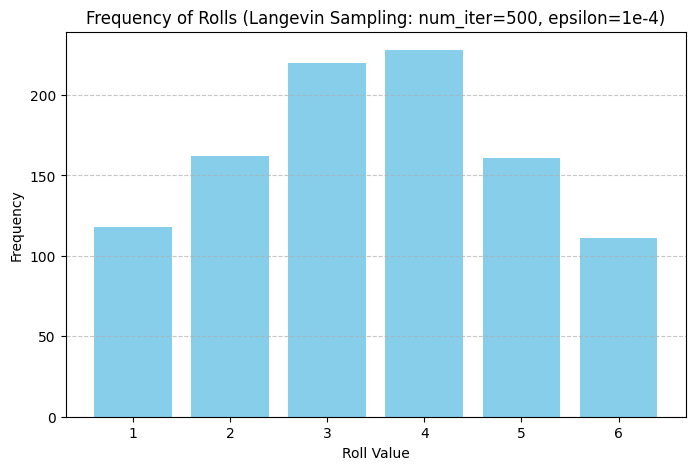

In [518]:
langevin_die_samples = [roll_dice_langevin(dice_roll_gradient_fn, num_iter=500, epsilon=1e-4) for _ in range(1000)]
print(langevin_die_samples)
plot_dice_roll_frequency(langevin_die_samples, title="Frequency of Rolls (Langevin Sampling: num_iter=500, epsilon=1e-4)")

[4, 1, 4, 2, 2, 2, 3, 1, 5, 1, 1, 1, 2, 4, 6, 2, 3, 1, 6, 5, 3, 2, 6, 3, 3, 3, 6, 5, 5, 3, 5, 3, 3, 4, 6, 2, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 6, 2, 5, 3, 4, 3, 6, 2, 3, 1, 3, 1, 5, 3, 5, 3, 3, 4, 4, 5, 6, 1, 5, 5, 5, 1, 4, 6, 5, 4, 2, 1, 1, 5, 2, 4, 2, 1, 3, 1, 2, 6, 5, 5, 6, 2, 2, 6, 6, 4, 4, 2, 2, 3, 6, 6, 5, 1, 3, 6, 3, 2, 3, 5, 2, 6, 4, 1, 1, 2, 3, 6, 4, 6, 3, 4, 6, 2, 6, 5, 6, 5, 4, 6, 3, 4, 5, 3, 5, 5, 2, 3, 5, 6, 4, 4, 2, 6, 2, 3, 1, 1, 5, 1, 4, 1, 1, 1, 1, 5, 4, 3, 5, 1, 1, 6, 6, 6, 5, 1, 4, 2, 4, 3, 4, 3, 4, 5, 2, 3, 4, 4, 4, 3, 3, 5, 1, 6, 1, 2, 1, 6, 3, 3, 5, 4, 2, 2, 4, 3, 1, 5, 4, 1, 1, 4, 5, 2, 5, 2, 5, 3, 2, 4, 5, 4, 2, 2, 3, 4, 3, 2, 4, 4, 4, 4, 5, 4, 2, 5, 5, 2, 5, 5, 2, 1, 3, 2, 5, 2, 5, 2, 6, 1, 2, 3, 5, 3, 4, 2, 6, 3, 3, 5, 5, 5, 4, 5, 1, 4, 6, 6, 3, 5, 2, 3, 6, 2, 1, 5, 5, 3, 4, 5, 4, 1, 3, 2, 2, 4, 4, 3, 6, 2, 2, 5, 1, 6, 2, 4, 5, 1, 2, 1, 3, 3, 1, 4, 2, 5, 6, 4, 2, 6, 3, 2, 5, 4, 1, 1, 4, 1, 3, 3, 2, 6, 3, 6, 2, 6, 5, 4, 5, 6, 3, 5, 2, 3, 2, 3, 4, 1, 5, 3, 

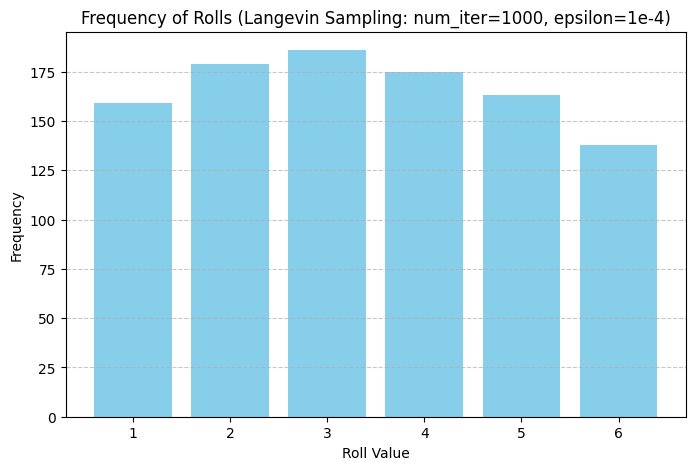

In [513]:
langevin_die_samples = [roll_dice_langevin(dice_roll_gradient_fn, num_iter=1000, epsilon=1e-4) for _ in range(1000)]
print(langevin_die_samples)
plot_dice_roll_frequency(langevin_die_samples, title="Frequency of Rolls (Langevin Sampling: num_iter=1000, epsilon=1e-4)")